<a href="https://colab.research.google.com/github/ll3462/NMA2020_Steinmetz_RL_decision/blob/master/temporal_generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1VzXljZTyVDjNXzF-j6pyyuPXU3CHU1T0'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data.zip')

In [ ]:
file_id = '15Sv4oCvgFgfc5pbiZPLMNFyc-baHsmja'
download_ = drive.CreateFile({'id':file_id})
download_.GetContentFile('brain_area.npy')

In [ ]:
ls

sample_data/


In [ ]:
from zipfile import PyZipFile

In [ ]:
pzf = PyZipFile('data.zip')
pzf.extractall()

In [ ]:
ls

adc.json  brain_area.npy  data.zip  sample_data/  steinmetz_data_session11/


In [ ]:
cd steinmetz_data_session11/

/content/steinmetz_data_session11


In [ ]:
try:
    import mne
except:
    !pip install mne

     |████████████████████████████████| 6.6MB 7.1MB/s 


In [ ]:
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from mne.decoding import GeneralizingEstimator

from collections import Counter


from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
brain_area = np.load('../brain_area.npy')

In [ ]:
Counter(brain_area)

Counter({'ACA': 16,
         'CA1': 50,
         'DG': 65,
         'LGd': 11,
         'LH': 18,
         'MD': 126,
         'MOs': 6,
         'PL': 56,
         'SUB': 105,
         'VISam': 79,
         'VISp': 66,
         'root': 100})

# preprocessing

In [ ]:
bin_size = np.load('bin_size.npy')
response = np.load('response.npy')
spikes = np.load('spks.npy')


spikes = np.swapaxes(spikes,0,1)

# use a window size of 5 time point to make convolution
window = np.ones(5)/5

features = []
for trial in spikes:
    _trial = []
    for neuron in trial:
        temp = np.convolve(neuron,window,mode = 'full')
        _trial.append(temp)
    features.append(_trial)

features = np.array(features)

In [ ]:
print(features.shape,response.shape)

(340, 698, 254) (340,)


In [ ]:
Counter(response)

Counter({-1.0: 141, 0.0: 64, 1.0: 135})

In [ ]:
response = response + 1

# use the features to predict the response in the same trial (I did only 1 fold of cross validation)

In [ ]:
df_idx = pd.DataFrame(brain_area.reshape(-1,1),columns = ['area'])
idx_sort = list(df_idx.sort_values(['area']).index)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(features,response,test_size = 0.3,shuffle = True,random_state = 12345)
clf = make_pipeline(StandardScaler(),LinearSVC(penalty = 'l1',random_state = 12345,dual = False,))
time_gen = GeneralizingEstimator(clf,scoring = 'accuracy',n_jobs = -1,verbose = 1)
time_gen.fit(X = X_train,
             y = y_train,
             )

<GeneralizingEstimator(base_estimator=Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=False,
                           fit_intercept=True, intercept_...1', random_state=12345,
                           tol=0.0001, verbose=0))],
         verbose=False),
           n_jobs=-1, scoring='accuracy', verbose=1, fitted with 254 estimators, fitted with 254 estimators>

In [ ]:
scores_same = time_gen.score(X = X_test,
                        y = y_test,
                        )

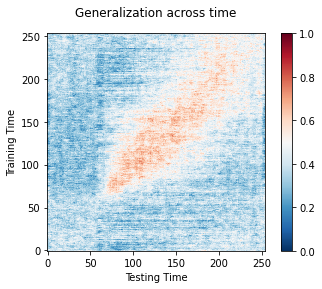

In [ ]:
fig, ax = plt.subplots(1)
im = ax.matshow(scores_same, vmin=0, vmax=1., cmap='RdBu_r', origin='lower',
                )
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Testing Time')
ax.set_ylabel('Training Time')
ax.set_title('Generalization across time')
plt.colorbar(im, ax=ax)

# look at the weights of the different brain areas

In [ ]:
weights = []
for est in time_gen.estimators_:
    weights.append(est.steps[-1][-1].coef_[-1])
weights = np.array(weights)
weights.shape

(254, 698)

In [ ]:
df_sort = df_idx.sort_values(['area']).reset_index()
k = {roi:np.mean(df_sub.index) for roi,df_sub in df_sort.groupby(['area'])}
k

{'ACA': 7.5,
 'CA1': 40.5,
 'DG': 98.0,
 'LGd': 136.0,
 'LH': 150.5,
 'MD': 222.5,
 'MOs': 288.5,
 'PL': 319.5,
 'SUB': 400.0,
 'VISam': 492.0,
 'VISp': 564.5,
 'root': 647.5}

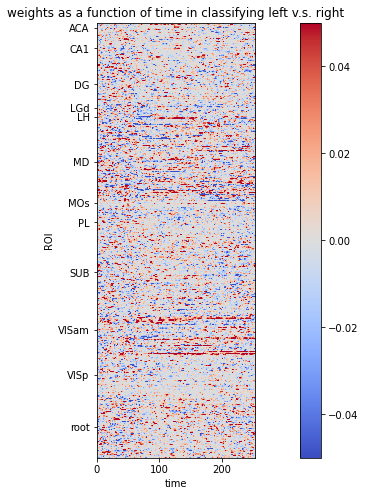

In [ ]:
fig,ax = plt.subplots(figsize = (16,8))
im = ax.imshow(weights[:,idx_sort].T,
               vmin = -.05,vmax = .05,
               cmap = plt.cm.coolwarm,
               aspect = 'equal')
ax.set(yticks = list(k.values()),
       yticklabels = list(k.keys()),
       xlabel = 'time',ylabel = 'ROI',
       title = 'weights as a function of time in classifying left v.s. right')
plt.colorbar(im)

# use the brain activities from the previous trial to predict the currect trial

In [ ]:
features_previous_trial = features[:-1] # remove the last trial
response_current_trial = response[1:] # remove the first trial

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(features_previous_trial,response_current_trial,test_size = 0.3,shuffle = True,random_state = 12345)
clf = make_pipeline(StandardScaler(),LinearSVC(penalty = 'l1',random_state = 12345,dual = False,))
time_gen = GeneralizingEstimator(clf,scoring = 'accuracy',n_jobs = -1,verbose = 1)
time_gen.fit(X = X_train,
             y = y_train,
             )

<GeneralizingEstimator(base_estimator=Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=False,
                           fit_intercept=True, intercept_...1', random_state=12345,
                           tol=0.0001, verbose=0))],
         verbose=False),
           n_jobs=-1, scoring='accuracy', verbose=1, fitted with 254 estimators, fitted with 254 estimators>

In [ ]:
scores = time_gen.score(X = X_test,
                        y = y_test,
                        )

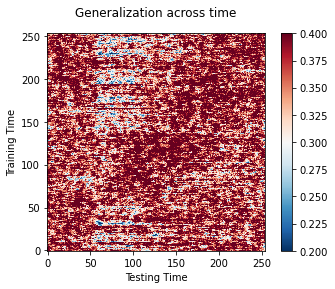

In [ ]:
fig, ax = plt.subplots(1)
im = ax.matshow(scores, vmin=0.2, vmax=.4, cmap='RdBu_r', origin='lower',
                )
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Testing Time')
ax.set_ylabel('Training Time')
ax.set_title('Generalization across time')
plt.colorbar(im, ax=ax)